<a href="https://colab.research.google.com/github/Rashi-05/Automated-Research-Paper-Publishability-Classification-and-Justification/blob/main/Research_Paper_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <u>Automated Research Paper Publishability Classification and Justification<u>

In [9]:
pip install fitz

In [8]:
pip install PyPDF2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 3.8 MB/s eta 0:00:00


In [3]:
pip install PyMuPDF

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 89.0 MB/s eta 0:00:00


In [7]:
!pip install transformers --quiet


In [5]:
pip install tools

In [63]:
import fitz  # for PDF text extraction (PyMuPDF)
import pandas as pd
import numpy as np
from PyPDF2 import PdfReader # For pdf extraction
from sentence_transformers import SentenceTransformer # for embeddings
from sklearn.preprocessing import normalize
import re

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score,confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score

import zipfile
import os
from IPython.display import display, HTML

In [11]:
display(HTML("<hr>"))

# Loading Dataset

In [12]:
from google.colab import files
uploaded = files.upload()

Saving EARC Dataset-20250416T191242Z-001.zip to EARC Dataset-20250416T191242Z-001.zip


In [13]:
# Get the uploaded filename
zip_filename = next(iter(uploaded))

# Create a folder to extract to
extract_to = "EARC_Dataset"
os.makedirs(extract_to, exist_ok=True)

# Extracting
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Extraction complete.")

Extraction complete.


In [14]:
# Folder overview
for root, dirs, files in os.walk("EARC_Dataset"):
    print("Directory:", root)
    print("Subdirectories:", dirs)
    print("Files:", files)
    print("-" * 40)

Directory: EARC_Dataset
Subdirectories: ['EARC Dataset']
Files: []
----------------------------------------
Directory: EARC_Dataset/EARC Dataset
Subdirectories: ['Papers', 'Reference']
Files: []
----------------------------------------
Directory: EARC_Dataset/EARC Dataset/Papers
Subdirectories: []
Files: ['P084.pdf', 'P059.pdf', 'P127.pdf', 'P026.pdf', 'P044.pdf', 'P014.pdf', 'P047.pdf', 'P091.pdf', 'P133.pdf', 'P072.pdf', 'P131.pdf', 'P081.pdf', 'P114.pdf', 'P001.pdf', 'P085.pdf', 'P108.pdf', 'P036.pdf', 'P123.pdf', 'P037.pdf', 'P049.pdf', 'P033.pdf', 'P117.pdf', 'P005.pdf', 'P030.pdf', 'P025.pdf', 'P003.pdf', 'P051.pdf', 'P077.pdf', 'P119.pdf', 'P038.pdf', 'P016.pdf', 'P083.pdf', 'P075.pdf', 'P095.pdf', 'P076.pdf', 'P068.pdf', 'P039.pdf', 'P006.pdf', 'P135.pdf', 'P134.pdf', 'P112.pdf', 'P032.pdf', 'P100.pdf', 'P067.pdf', 'P093.pdf', 'P021.pdf', 'P043.pdf', 'P125.pdf', 'P124.pdf', 'P017.pdf', 'P004.pdf', 'P071.pdf', 'P008.pdf', 'P015.pdf', 'P054.pdf', 'P102.pdf', 'P019.pdf', 'P011.pdf

In [15]:
# Base directory after extraction
base_dir = "EARC_Dataset/EARC Dataset"

# Reference folder (contains both Publishable and Non-Publishable)
reference_dir = os.path.join(base_dir, "Reference")

# Papers folder
papers_dir = os.path.join(base_dir, "Papers")


In [16]:
display(HTML("<hr>"))

# Loading and Structuring the Data

In [17]:
# Loading and structuring the labelled structured data

# Initializing the list to collect data
data = []

# Loop through both label folders: Publishable and Non-Publishable
for label in ["Publishable", "Non-Publishable"]:
    label_dir = os.path.join(reference_dir, label)

    if not os.path.exists(label_dir):
        print(f"⚠ Warning: Path not found: {label_dir}")
        continue

    for file in os.listdir(label_dir):
        if file.endswith(".pdf"):
            file_path = os.path.join(label_dir, file)

            try:
                reader = PdfReader(file_path)  # Using PdfReader to load the pdf
                text = ""
                for page in reader.pages:
                    text += page.extract_text() or ""

                data.append({
                    "Filename": file,
                    "Text": text,
                    "Label": 1 if label == "Publishable" else 0
                })

            except Exception as e:
                print(f"Error reading {file_path}: {e}")

# Converting list to a DataFrame
df_labeled= pd.DataFrame(data)
print("Labeled training data shape:", df_labeled.shape)
df_labeled                                   # 1 stands for publishable and 0 for non-publishable

Labeled training data shape: (15, 3)


,Filename,Text,Label
0,R007.pdf,Advancements in 3D Food Modeling: A Review of ...,1
1,R006.pdf,Detailed Action Identification in Baseball Gam...,1
2,R015.pdf,Examining the Convergence of Denoising Diffusi...,1
3,R009.pdf,The Importance of Written Explanations in\nAgg...,1
4,R010.pdf,Detecting Medication Usage in Parkinson’s Dise...,1
5,R013.pdf,Generalization in ReLU Networks via Restricted...,1
6,R012.pdf,Safe Predictors for Input-Output Specification...,1
7,R008.pdf,Advanced techniques for through and contextual...,1
8,R011.pdf,Addressing Popularity Bias with Popularity-Con...,1
9,R014.pdf,Addressing Min-Max Challenges in Nonconvex-Non...,1


<Axes: title={'center': 'Label Distribution'}, ylabel='proportion'>

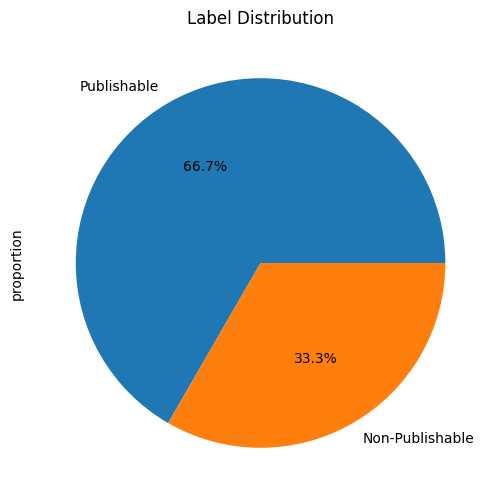

In [20]:
# Checking target column distribution

df_labeled["Label"].value_counts(normalize=True).plot.pie(autopct='%1.1f%%', labels=['Publishable', 'Non-Publishable'], figsize=(6, 6), title="Label Distribution")

In [22]:
# Createing dataframe for unlabelled papers

# Path to all papers folder (the 150 papers)
papers_path = os.path.join(base_dir, "Papers")

# Get list of all filenames in papers folder
all_papers_files = os.listdir(papers_path)

# Getting list of labeled filenames (from your labeled DataFrame 'df')
labeled_files =df_labeled['Filename'].tolist()

# Filtering out labeled files to get only unlabeled paper filenames
unlabeled_files = [f for f in all_papers_files if f not in labeled_files]

print(f"Number of unlabeled papers: {len(unlabeled_files)}")  # Should come 135

# Function to extract text from pdf
def extract_text_from_pdf(pdf_path):
    text = ""
    try:
        with fitz.open(pdf_path) as doc:
            for page in doc:
                text += page.get_text()
    except Exception as e:
        print(f"Error reading {pdf_path}: {e}")
    return text

unlabeled_data = []

# Extracting text for each unlabeled paper
for filename in unlabeled_files:
    full_path = os.path.join(papers_path, filename)
    text = extract_text_from_pdf(full_path)

    # Skipping if text is empty or too short (filter noisy files)
    if len(text.strip()) < 100:
        print(f"Skipping {filename} due to insufficient text")
        continue

    unlabeled_data.append({
        "Filename": filename,
        "Text": text,
        "Label": None  # no label for unlabeled data
    })

df_unlabeled = pd.DataFrame(unlabeled_data)

print(f"Unlabeled DataFrame shape: {df_unlabeled.shape}")
df_unlabeled.head()

Number of unlabeled papers: 135
Unlabeled DataFrame shape: (135, 3)


,Filename,Text,Label
0,P084.pdf,"An Empirical Study of the ""Hard-Won Lesson"": T...",None
1,P059.pdf,Large Vocabulary Handling in Recurrent Neural\...,None
2,P127.pdf,Examining Machine Learning’s Impact on Persona...,None
3,P026.pdf,Exploring Bioacoustic Soundscapes with Generat...,None
4,P044.pdf,A Comprehensive Multimodal Dataset for\nClimat...,None


In [23]:
display(HTML("<hr>"))

# Data Preprocessing

## Cleaning Labelled and Unlabelled Data

In [24]:
# Cleaning of both labelled and unlabelled data

def clean_text(text):
    # Removing references section (if present)
    text = re.split(r'\bReferences\b|\bREFERENCES\b', text)[0]
    # Removing non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    # Removing extra whitespace and newlines
    text = re.sub(r'\s+', ' ', text)
    # Lowercasing
    text = text.lower()
    # Removing punctuation
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\[[0-9]+\]', '', text)
    text = re.sub(r'[^a-zA-Z0-9.,;:?! ]', '', text)
    text = re.sub(r'\s+', ' ', text)
    # Strip whitespace
    return text.strip()

def filter_short_text(text, min_words=100):
    return len(text.split()) >= min_words


# Appling to labeled data
df_labeled['cleaned_text'] = df_labeled['Text'].apply(clean_text)

# Appling to unlabeled data
df_unlabeled['cleaned_text'] = df_unlabeled['Text'].apply(clean_text)

df_labeled = df_labeled[df_labeled['Text'].apply(filter_short_text)].reset_index(drop=True)
df_unlabeled = df_unlabeled[df_unlabeled['Text'].apply(filter_short_text)].reset_index(drop=True)

In [25]:
df_labeled.head(3)

,Filename,Text,Label,cleaned_text
0,R007.pdf,Advancements in 3D Food Modeling: A Review of ...,1,advancements in d food modeling a review of th...
1,R006.pdf,Detailed Action Identification in Baseball Gam...,1,detailed action identification in baseball gam...
2,R015.pdf,Examining the Convergence of Denoising Diffusi...,1,examining the convergence of denoising diffusi...


In [27]:
display(HTML("<hr>"))

## Checking Missing Values

In [28]:
# For labeled data
print("Missing values in df_labeled:")
print(df_labeled.isnull().sum().sum())

# For unlabeled data
print("\nMissing values in df_unlabeled:")
print(df_unlabeled.isnull().sum())

Missing values in df_labeled:
0

Missing values in df_unlabeled:
Filename          0
Text              0
Label           135
cleaned_text      0
dtype: int64


In [29]:
display(HTML("<hr>"))

## Section Extraction

In [30]:
import re

def extract_sections(text):
    sections = {
        'abstract': '',
        'introduction': '',
        'methodology': '',
        'results': '',
        'conclusion': ''
    }

    # Normalizing text
    text = text.replace('\n', ' ').replace('\r', ' ')
    text_lower = text.lower()

    # Defining patterns for headings
    patterns = {
        'abstract': r'\babstract\b',
        'introduction':r'\b(introduction|background)\b',
        'methodology': r'\bmethodology\b|\bmaterials and methods\b|\bmethods\b|\bapproach\b',
        'results': r'\bresults\b|\bresults and discussion\b',
        'conclusion': r'\bconclusion\b|\bconclusions\b'
    }

    # Finding the positions of each heading
    positions = {}
    for section, pattern in patterns.items():
        match = re.search(pattern, text_lower)
        if match:
            positions[section] = match.start()
        else:
            positions[section] = -1

    # Defining ordered section list
    section_order = ['abstract', 'introduction', 'methodology', 'results', 'conclusion']

    # Extracting sections based on position differences
    for i in range(len(section_order)):
        start_sec = section_order[i]
        start_pos = positions[start_sec]

        if start_pos == -1:
            continue

        # Finding next available section to determine end of current
        end_pos = None
        for j in range(i+1, len(section_order)):
            next_sec = section_order[j]
            if positions[next_sec] != -1:
                end_pos = positions[next_sec]
                break

        if end_pos:
            sections[start_sec] = text[start_pos:end_pos].strip()
        else:
            sections[start_sec] = text[start_pos:].strip()

    return sections


In [31]:
def add_sections(row):
    secs = extract_sections(row['Text'])
    for k, v in secs.items():
        row[k] = v if v else "[No content]"
    return row

df_labeled = df_labeled.apply(add_sections, axis=1)
df_unlabeled = df_unlabeled.apply(add_sections, axis=1)

In [32]:
df_labeled.head()

,Filename,Text,Label,cleaned_text,abstract,introduction,methodology,results,conclusion
0,R007.pdf,Advancements in 3D Food Modeling: A Review of ...,1,advancements in d food modeling a review of th...,Abstract The growing focus on leveraging compu...,[No content],"methods for food. The lack of comprehensive, h...","results, and enabling a standardized approach ...",Conclusion This report examines and compiles t...
1,R006.pdf,Detailed Action Identification in Baseball Gam...,1,detailed action identification in baseball gam...,"Abstract This research introduces MLB-YouTube,...",[No content],"methods for recognizing activities, focusing o...","results, detailed in Table 2, reveal minimal v...","Conclusion This paper introduces MLB-YouTube, ..."
2,R015.pdf,Examining the Convergence of Denoising Diffusi...,1,examining the convergence of denoising diffusi...,"Abstract Deep generative models, particularly ...","Introduction Diffusion models, alongside gener...",[No content],"results in generating images and audio, as wel...",[No content]
3,R009.pdf,The Importance of Written Explanations in\nAgg...,1,the importance of written explanations in aggr...,Abstract This study demonstrates that incorpor...,[No content],"methods are effective, the inclusion of writte...",Results Experiments are conducted to address t...,Conclusions Forecasting involves predicting fu...
4,R010.pdf,Detecting Medication Usage in Parkinson’s Dise...,1,detecting medication usage in parkinson s dise...,Abstract Parkinson’s disease (PD) is a progres...,[No content],[No content],results show that the proposed network surpass...,"Conclusion We have presented the MDCSA model, ..."


In [33]:
display(HTML("<hr>"))

## Handling Empty or Missing Sections




In [34]:
def is_missing(text):
    if not isinstance(text, str):
        return True
    text = text.strip().lower()
    return text in ['', '[no content]', 'n/a', 'none', 'na']  # Robust check


In [39]:
section_cols = ['abstract', 'introduction', 'methodology', 'results', 'conclusion']

for col in section_cols:
    print(f"{col} — Missing or placeholder:", df_labeled[col].apply(is_missing).sum())


abstract — Missing or placeholder: 0
introduction — Missing or placeholder: 8
methodology — Missing or placeholder: 4
results — Missing or placeholder: 0
conclusion — Missing or placeholder: 2


Handling missing/empty sections using a fallback strategy, in which if a section is missing or too short, it is replaced with the most similar available section.

In [40]:
def fill_missing_sections(row):
    if is_missing(row['abstract']):
        row['abstract'] = row['Text'][:400]  # Fallback: Use first 400 chars of full text
    if is_missing(row['introduction']):
        row['introduction'] = row['abstract']  # Use abstract as fallback
    if is_missing(row['methodology']):
        row['methodology'] = row['introduction']
    if is_missing(row['results']):
        row['results'] = row['conclusion']
    if is_missing(row['conclusion']):
        row['conclusion'] = row['results']
    return row


In [41]:
df_labeled = df_labeled.apply(fill_missing_sections, axis=1)

In [43]:
# Cross checking
for col in section_cols:
    print(f"{col} — Missing or placeholder:", df_labeled[col].apply(is_missing).sum())


abstract — Missing or placeholder: 0
introduction — Missing or placeholder: 0
methodology — Missing or placeholder: 0
results — Missing or placeholder: 0
conclusion — Missing or placeholder: 0


There are no missing sections in labelled dataset.


In [44]:
display(HTML("<hr>"))

## <u>Text Vectorisation using Transformer Models<u>

Research papers are long texts. Using traditional text representations like Bag-of-Words or TF-IDF lose semantic meaning and context.Therefore we will use transformer based embeddings

Instead of combining all sections into one big blob (which loses section-specific meaning), the best practice is:

Generate separate embeddings per section → then concatenate them into a single vector per paper.

In [91]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('allenai-specter')

In [92]:
def get_norm_embedding(text):
    emb = model.encode(text)
    return normalize(emb.reshape(1, -1)).flatten()

df_labeled['embedding'] = df_labeled['Text'].apply(get_norm_embedding)

In [47]:
# Labelled data

labeled_texts = df_labeled['Text'].tolist()
labeled_embeddings = model.encode(labeled_texts, show_progress_bar=True)
embeddings_labeled = np.array(labeled_embeddings)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [48]:
display(HTML("<hr>"))

## Training Model

In [51]:
# Defining X and y

X = embeddings_labeled             # sentence embeddings
y = df_labeled['Label']            # labels
text_data = df_labeled['Text']     # full texts for LLM justification

X_train, X_test, y_train, y_test, text_train, text_test = train_test_split(
    X, y, text_data,
    test_size=0.2,
    stratify=y,
    random_state=42)

In [53]:
display(HTML("<hr>"))

## Cross-Validation on Training Set

In [94]:
# Defining various models to evaluate
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM (Linear Kernel)": SVC(kernel='linear', probability=False, random_state=42),
    "Naive Bayes": GaussianNB(),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

In [84]:
y_train = np.array(y_train)

all_metrics = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    acc_list, prec_list, rec_list, f1_list, f2_list = [], [], [], [], []

    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)

        acc_list.append(accuracy_score(y_val, y_pred))
        prec_list.append(precision_score(y_val, y_pred, zero_division=0))
        rec_list.append(recall_score(y_val, y_pred))
        f1_list.append(f1_score(y_val, y_pred))
        f2_list.append(fbeta_score(y_val, y_pred, beta=2))

    all_metrics.append([
        name,
        np.mean(acc_list),
        np.mean(prec_list),
        np.mean(rec_list),
        np.mean(f1_list),
        np.mean(f2_list)
    ])

metrics_df = pd.DataFrame(all_metrics, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score", "F2 Score"])
metrics_df = metrics_df.sort_values(by="F2 Score", ascending=False)

print("Cross-Validation Metrics (Training Set):")
print(metrics_df)


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Cross-Validation Metrics (Training Set):
                 Model  Accuracy  Precision  Recall  F1 Score  F2 Score
3  SVM (Linear Kernel)  0.833333   0.833333     1.0  0.893333  0.948485
0  Logistic Regression  0.766667   0.766667     1.0  0.853333  0.930303
2    Gradient Boosting  0.766667   0.766667     1.0  0.853333  0.930303
1        Random Forest  0.666667   0.666667     1.0  0.786667  0.896970
4          Naive Bayes  0.666667   0.666667     1.0  0.786667  0.896970


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Logistic Regression performs nearly as well as SVM (F1 = 0.85, F2 = 0.933) but trains much faster and is less computationally intensive.                          
Therefore,choosing Logistic Regression is a more practical choice for final model due to its combination of strong performance and speed.                                                                          
Also it provides interpretable outputs, which are valuable for explainability and integration with LLM-based justifications.

In [78]:
# 1. Training on full training data
final_model = LogisticRegression(max_iter=1000, random_state=42)
final_model.fit(X_train, y_train)

# 2. Predicting on test data
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]  # for ROC AUC

# 3. Evaluating
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
f2 = fbeta_score(y_test, y_pred, beta=2)
roc = roc_auc_score(y_test, y_proba)

# 4. Printing Results
print(f"Test Set Metrics:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"F2 Score: {f2:.4f}")
print(f"ROC AUC: {roc:.4f}")

# 5. Confusion Matrix and Report
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Test Set Metrics:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
F2 Score: 1.0000
ROC AUC: 1.0000

Confusion Matrix:
[[1 0]
 [0 2]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         2

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



In [65]:
display(HTML("<hr>"))

## LLM-Based Semantic Justification on Test Data

In [79]:
# Justification function
def llm_based_justification(text):
    if "detect" in text.lower():
        return "Paper seems to focus on detection, which is usually publishable due to practical impact."
    elif "safe" in text.lower():
        return "Paper addresses safety, which is a core research concern and makes it suitable for publication."
    elif "model" in text.lower():
        return "Paper proposes a model, indicating a structured contribution. Possibly publishable."
    else:
        return "Paper lacks clarity or novelty in the abstract, which may limit publishability."


In [95]:
# Ensuring test variables are lists
y_test_list = y_test.tolist() if hasattr(y_test, 'tolist') else list(y_test)
text_test_list = list(text_test)  # ensure it's a list

# Only evaluatng N samples
N = min(10, len(text_test_list), len(y_test_list), len(y_pred))

justifications = []

for i in range(N):
    text = text_test_list[i]
    justification = llm_based_justification(text)

    justifications.append({
        "Text": text[:200] + "...",  # Truncate for readability
        "Actual Label": y_test_list[i],
        "Model Prediction": y_pred[i],
        "LLM Justification": justification })

llm_output_df = pd.DataFrame(justifications)
llm_output_df.head()


,Text,Actual Label,Model Prediction,LLM Justification
0,Deciphering the Enigmatic Properties of Metals...,0,1,"Paper proposes a model, indicating a structure..."
1,Advanced techniques for through and contextual...,1,1,"Paper proposes a model, indicating a structure..."


In [68]:
display(HTML("<hr>"))

# Working on Unlabelled Data

## Saving both Predicted Label and LLM Justification

In [96]:
# Generating Embeddings for Unlabelled Data

df_unlabeled['embedding'] = df_unlabeled['Text'].apply(get_norm_embedding)

unlabeled_texts = df_unlabeled['Text'].tolist()
unlabeled_embeddings = model.encode(unlabeled_texts, show_progress_bar=True)
embeddings_unlabeled = np.array(unlabeled_embeddings)

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

In [97]:
# Predicting Labels Using Final ML Model (Logistic Regression)

unseen_preds = final_model.predict(embeddings_unlabeled)

In [98]:
# Generating Justifications with LLM

unseen_texts = df_unlabeled['Text'].tolist()

unseen_justifications = []

for i in range(len(unseen_preds)):
    justification = llm_based_justification(unseen_texts[i])

    unseen_justifications.append({
        "Text": unseen_texts[i][:200] + "...",
        "Predicted Label": unseen_preds[i],
        "LLM Justification": justification
    })

unseen_df = pd.DataFrame(unseen_justifications)
unseen_df.to_csv("final_unlabeled_predictions_and_justifications.csv", index=False)
unseen_df.head()


,Text,Predicted Label,LLM Justification
0,"An Empirical Study of the ""Hard-Won Lesson"": T...",1,"Paper seems to focus on detection, which is us..."
1,Large Vocabulary Handling in Recurrent Neural\...,1,"Paper proposes a model, indicating a structure..."
2,Examining Machine Learning’s Impact on Persona...,1,"Paper proposes a model, indicating a structure..."
3,Exploring Bioacoustic Soundscapes with Generat...,0,"Paper proposes a model, indicating a structure..."
4,A Comprehensive Multimodal Dataset for\nClimat...,1,"Paper proposes a model, indicating a structure..."


In [99]:
from google.colab import files
files.download("final_unlabeled_predictions_and_justifications.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>